### Testing FD Methods (Gauss-Seidel/Jacobi) on Different Shapes

I'm not able to get the jax functions working, wasn't able to figure out how to handle compiling conditional statements for the mask

In [1]:
import jax.numpy as jnp
from jax import Array

def init_rectangle(nx: int, ny: int, boundaries: Array | None = None) -> Array:
    """
    Initialize the solution matrix with the boundary values.

    Args:
        nx: number of grid points in x direction
        ny: number of grid points in y direction
        boundaries: list of boundary values [top, bottom, left, right]
    Returns:
        solution: initialized solution matrix
    """
    if boundaries is None:
        boundaries = jnp.zeros(4)
    mean_value = jnp.mean(boundaries)
    # n + 2 to include the boundary values
    solution = mean_value * jnp.ones((ny + 2, nx + 2))

    # set the boundary values
    solution = solution.at[0, :].set(boundaries[0])  # top
    solution = solution.at[-1, :].set(boundaries[1])  # bottom
    solution = solution.at[:, 0].set(boundaries[2])  # left
    solution = solution.at[:, -1].set(boundaries[3])  # right

    return solution

In [2]:
def init_Ushape(nx: int, ny: int, boundaries: Array | None = None) -> Array:
    """
    Initialize the solution matrix with the boundary values.
    Assume the 'neck' of the U is 1/4 the domain height and 1/2 domain width
    Let negative values denote out of domain values

    Args:
        nx: number of grid points in x direction
        ny: number of grid points in y direction
        boundaries: list of boundary values [top, bottom, left, right]
    Returns:
        solution: initialized solution matrix
    """
    if boundaries is None:
        boundaries = jnp.zeros(4)
    mean_value = jnp.mean(boundaries)
    # n + 2 to include the boundary values
    solution = mean_value * jnp.ones((ny + 2, nx + 2))
    mask = jnp.ones((ny + 2, nx + 2))

    # set the boundary values
    solution = solution.at[0, :].set(boundaries[0])  # top
    mask = mask.at[0, :].set(0)
    solution = solution.at[-1, :].set(boundaries[1])  # bottom
    mask = mask.at[-1, :].set(0)
    solution = solution.at[:, 0].set(boundaries[2])  # left
    mask = mask.at[:, 0].set(0)
    solution = solution.at[:, -1].set(boundaries[3])  # right
    mask = mask.at[:, -1].set(0)

    # set the U shape
    neck_yend = int(jnp.round(3*ny/4))
    neck_xstart = int(jnp.round(nx/4))
    neck_xend = int(jnp.round(3*nx/4))

    solution = solution.at[:neck_yend, neck_xstart:neck_xend].set(-100)
    mask = mask.at[:neck_yend, neck_xstart:neck_xend].set(0)
    solution = solution.at[:neck_yend, neck_xstart].set(0)
    mask = mask.at[:neck_yend, neck_xstart].set(0)
    solution = solution.at[:neck_yend, neck_xend].set(0)
    mask = mask.at[:neck_yend, neck_xend].set(0)
    solution = solution.at[neck_yend, neck_xstart:neck_xend+1].set(0)
    mask = mask.at[neck_yend, neck_xstart:neck_xend+1].set(0)

    return solution, mask

In [34]:
def init_circle(nx: int, ny: int, boundaries: Array | None = None, eps: int = 0) -> Array:
    """
    Initialize the solution matrix with the boundary values.
    Fix the radius of the circle to be 1/2 the domain width
    Let negative values denote out of domain values

    Args:
        nx: number of grid points in x direction
        ny: number of grid points in y direction
        boundaries: list of boundary values [top, bottom]
    Returns:
        solution: initialized solution matrix
    """
    if boundaries is None:
        boundaries = jnp.zeros(2)
    mean_value = jnp.mean(boundaries)

    solution = mean_value * jnp.ones((ny, nx))
    mask = jnp.ones((ny, nx))

    center = (nx // 2, ny // 2)
    for i in range(ny):
        for j in range(nx):
            r = (i - center[1])**2 + (j - center[0])**2
            if r > (nx // 2)**2:
                solution = solution.at[i, j].set(-100)
                mask = mask.at[i, j].set(0)
            elif r > (nx // 2)**2 - eps and r < (nx // 2)**2 + eps  and i>center[1]:
                solution = solution.at[i, j].set(boundaries[0])
                mask = mask.at[i, j].set(0)
            elif r > (nx // 2)**2 - eps and r < (nx // 2)**2 + eps and i<center[1]:
                solution = solution.at[i, j].set(boundaries[1])
                mask = mask.at[i, j].set(0)
    
    return solution, mask

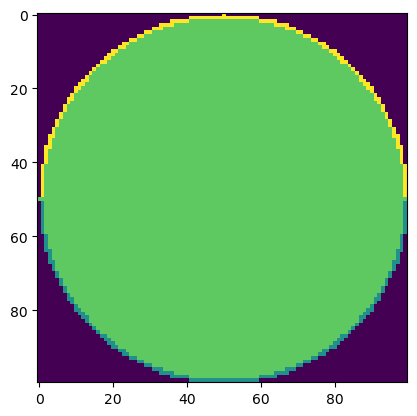

In [38]:
import matplotlib.pyplot as plt 
circle_init, mask = init_circle(100, 100, boundaries=jnp.array([0, 100]), eps=110)

plt.imshow(circle_init, cmap = 'viridis', interpolation='none', vmin=-100, vmax=100)

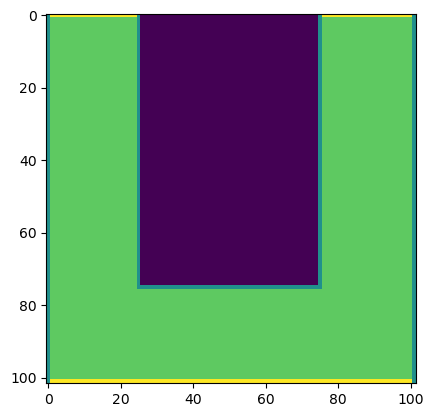

In [9]:
import matplotlib.pyplot as plt 
U_init, mask = init_Ushape(100, 100, boundaries=jnp.array([100, 100, 0, 0]))

plt.imshow(U_init, cmap = 'viridis', interpolation='none', vmin=-100, vmax=100)

In [40]:
import numpy as np 

def jacobi_np(x, n_iters=1, mask=None):
    """Jacobi method for solving an elliptic PDE."""
    n, m = x.shape
    xp = x.clone()

    for _ in range(n_iters):
        for i in range(1, n - 1):
            for j in range(1, m - 1):
                if mask is None: # if mask not provided, assume always update
                    x[i, j] = (xp[i - 1, j] + xp[i + 1, j] + xp[i, j - 1] + xp[i, j + 1]) / 4
                elif mask[i, j]: # if mask provided, only update if mask is True
                    x[i, j] = (xp[i - 1, j] + xp[i + 1, j] + xp[i, j - 1] + xp[i, j + 1]) / 4

        xp = x.clone()
    
    return x

def gauss_seidel_np(x, n_iters=1, mask=None):
    """Gauss-Seidel method for solving an elliptic PDE."""
    n, m = x.shape

    for _ in range(n_iters):
        for i in range(1, n - 1):
            for j in range(1, m - 1):
                if mask is None: # if mask not provided, assume always update
                    x[i, j] = (x[i - 1, j] + x[i + 1, j] + x[i, j - 1] + x[i, j + 1]) / 4
                elif mask[i, j]: # if mask provided, only update if mask is True
                    x[i, j] = (x[i - 1, j] + x[i + 1, j] + x[i, j - 1] + x[i, j + 1]) / 4
    
    return x

In [42]:
circle_init_np = np.array(circle_init)
mask_np = np.array(mask)
circle_solution = gauss_seidel_np(circle_init_np, n_iters=2000, mask=mask_np)

In [10]:
U_init_np = np.array(U_init)
mask_np = np.array(mask)
U_solution = gauss_seidel_np(U_init_np, n_iters=2000, mask=mask_np)

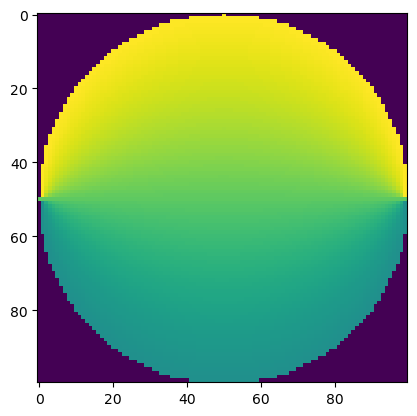

In [43]:
plt.imshow(circle_solution, cmap = 'viridis', interpolation='none', vmin=-100, vmax=100)

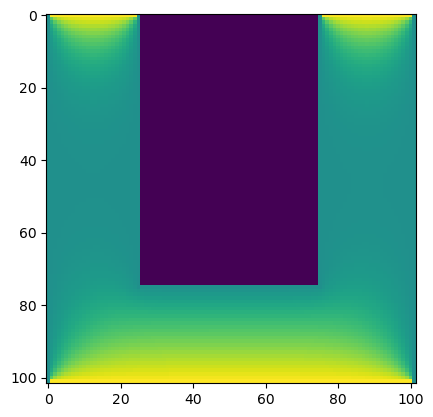

In [11]:
plt.imshow(U_solution, cmap = 'viridis', interpolation='none', vmin=-100, vmax=100)

### Matrix Methods

First use Fenics to assemble system matrix and forcing vector, then export to np array

In [78]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy 

shape = 'square'
save = False

if shape == 'square':
    #n = 100 # full-fidelity mesh when running final tests
    n = 20 # use smaller mesh size for testing
    mesh = UnitSquareMesh(n, n)

elif shape == "circle":
    res = 10 # lower resolution for testing
    #res = 25  # can increase this if more precision is needed
    circle = Circle(Point(0.0, 0.0), 1, 40) # center, radius, segments of circle
    mesh = generate_mesh(circle, res) # mesh, resolution

elif shape == "U":
    res = 10 # lower resolution for testing
    #res = 25  # can increase this if more precision is needed
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0)) # lower left, upper right
    u_void = Rectangle(Point(0.25, 0.25), Point(0.75, 1.0)) # lower left, upper right
    u_shape = square - u_void
    mesh = generate_mesh(u_shape, res) # mesh, resolution

V = FunctionSpace(mesh, "Lagrange", 1)

# Square Boundaries:
def left_boundary(x):
    return x[0] < DOLFIN_EPS

def right_boundary(x):
    return x[0] > 1.0 - DOLFIN_EPS

def top_boundary(x):
    return x[1] > 1.0 - DOLFIN_EPS

def bottom_boundary(x):
    return x[1] < DOLFIN_EPS

# Circle Boundaries:
eps = 1e-2 # eps needs to be higher than DOLFIN_EPS since mesh is too coarse for DOLFIN_EPS. May need to decrease this when going to higher res
def top_circumference_boundary(x): # apply boundary on the entire circumference
    r = math.sqrt(x[0] * x[0] + x[1] * x[1])
    # condition here is 1-eps < r < 1+eps and y > 0, which grabs points that are on circuference and above x-axis
    return r > 1.0 - eps and r < 1.0 + eps and x[1] > 0.0
def bottom_circumference_boundary(x):
    r = math.sqrt(x[0] * x[0] + x[1] * x[1])
    # condition here is 1-eps < r < 1+eps and y > 0, which grabs points that are on circuference and below x-axis
    return r > 1.0 - eps  and r < 1.0 + eps and x[1] < 0.0

# Define boundary condition
u0 = Constant(0.0)
uboundary = Constant(100.0)

if shape == 'square':
    bc_left = DirichletBC(V, uboundary, left_boundary)
    bc_right = DirichletBC(V, u0, right_boundary)
    bc_top = DirichletBC(V, u0, top_boundary)
    bc_bottom = DirichletBC(V, u0, bottom_boundary)
    bcs = [bc_left, bc_right, bc_top, bc_bottom]

elif shape == "circle":
    bc_top = DirichletBC(V, uboundary, top_circumference_boundary)
    bc_bottom = DirichletBC(V, u0, bottom_circumference_boundary)
    bcs = [bc_top, bc_bottom]

elif shape == "U":
    bc_left = DirichletBC(V, u0, left_boundary)
    bc_right = DirichletBC(V, u0, right_boundary)
    bc_top = DirichletBC(V, uboundary, top_boundary)
    bc_bottom = DirichletBC(V, uboundary, bottom_boundary)
    bcs = [bc_left, bc_right, bc_top, bc_bottom]

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.0)
g = Constant(0.0)

Ak = assemble(inner(grad(u), grad(v))*dx)
L = assemble(f*v*dx + g*v*ds)

for bc in bcs:
    bc.apply(Ak, L) 

Ak_np = Ak.array()
L_np = L.get_local()
coord_map = V.tabulate_dof_coordinates() # is a list of the coordinates of each of the solution points. 
#The ith entry in coordmap is the coordinate of the ith solution point in x after solving Ax=b

if save:
    np.save('data/Ak.npy', Ak_np)
    np.save('data/L.npy', L_np)
    np.save('data/coord_map.npy', coord_map)

# either sparse or regular solve
#u_np = scipy.linalg.solve(Ak_np, L_np)
u_np = scipy.sparse.linalg.spsolve(Ak_np, L_np)
print(max(u_np), min(u_np))

100.00000000000007 -3.5527136788005e-15


/tmp/ipykernel_262274/2898001876.py:103: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_np = scipy.sparse.linalg.spsolve(Ak_np, L_np)


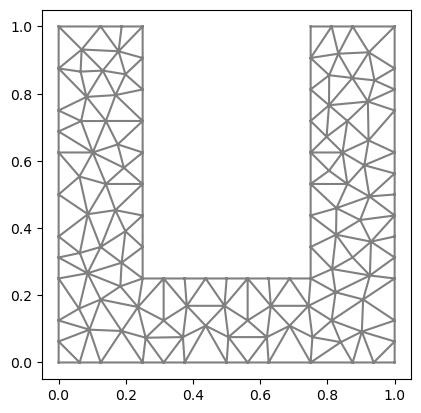

In [2]:
plot(mesh) # resolution 10 U mesh

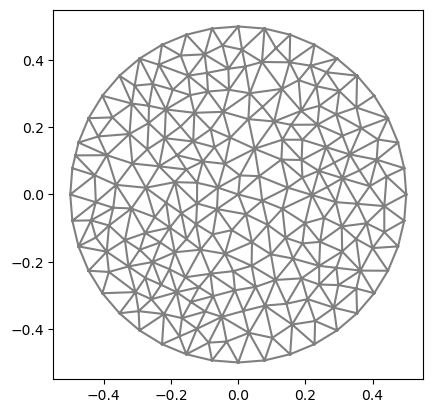

In [37]:
plot(mesh) # resolution 10 circle mesh

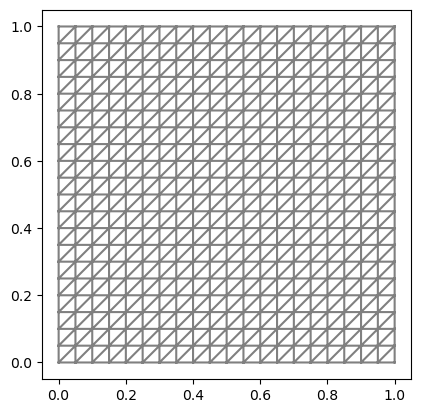

In [28]:
plot(mesh) # 20x20 square mesh

Number of DoFs: 133, mesh vertices: 133, size of unodalVals: (133,)


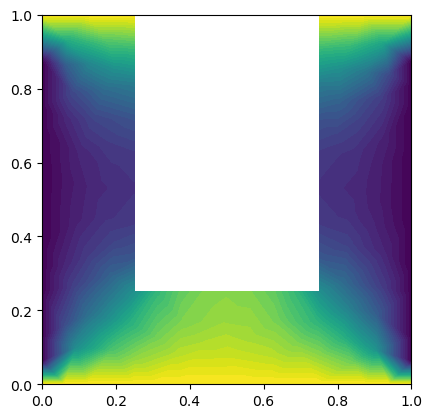

In [3]:
u = Function(V) # defines function on Mesh Space V
u.vector().set_local(u_np) # set the values of the function to the values of u_np

print(f"Number of DoFs: {V.dim()}, mesh vertices: {mesh.num_vertices()}, size of unodalVals: {u_np.shape}")

plot(u)
plt.show()

Number of DoFs: 217, mesh vertices: 217, size of unodalVals: (217,)


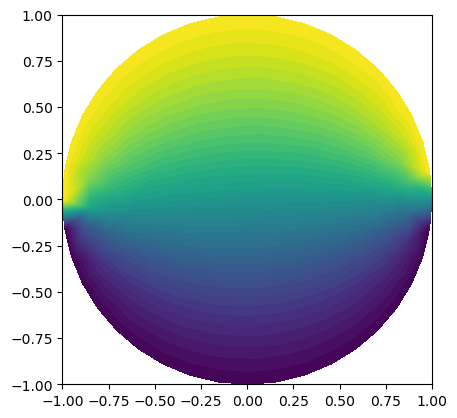

In [46]:
u = Function(V) # defines function on Mesh Space V
u.vector().set_local(u_np) # set the values of the function to the values of u_np

print(f"Number of DoFs: {V.dim()}, mesh vertices: {mesh.num_vertices()}, size of unodalVals: {u_np.shape}")

plot(u)
plt.show()

Number of DoFs: 441, mesh vertices: 441, size of unodalVals: (441,)


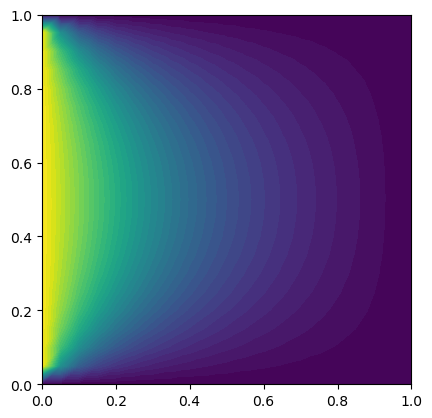

In [52]:
u = Function(V)
u.vector().set_local(u_np)

print(f"Number of DoFs: {V.dim()}, mesh vertices: {mesh.num_vertices()}, size of unodalVals: {u_np.shape}")

plot(u)
plt.show()

In [74]:
import matplotlib.pyplot as plt
from matplotlib import tri as mtri
import shapely
from shapely.geometry import Polygon as sPolygon

def plot_mesh_1(u, coords):
    # try 1, matplotlib makes unnecesary triangles
    x = coords[:, 0]
    y = coords[:, 1]

    triang = mtri.Triangulation(x, y)
    refiner = mtri.UniformTriRefiner(triang)
    tri_refi, z_test_refi = refiner.refine_field(u, subdiv=1)

    plt.figure()
    plt.gca().set_aspect('equal')
    plt.tricontourf(tri_refi, z_test_refi, levels=50)

def plot_mesh_2(u, coords, eps=0.2):
    # try 2, delete triangles larger than eps
    x = coords[:, 0]
    y = coords[:, 1]

    triang = mtri.Triangulation(x, y)

    # plot only triangles with sidelength smaller some max_radius
    triangles = triang.triangles

    # Mask off unwanted triangles.
    xtri = x[triangles] - np.roll(x[triangles], 1, axis=1)
    ytri = y[triangles] - np.roll(y[triangles], 1, axis=1)
    maxi = np.max(np.sqrt(xtri**2 + ytri**2), axis=1)
    triang.set_mask(maxi > eps)

    refiner = mtri.UniformTriRefiner(triang)
    tri_refi, z_test_refi = refiner.refine_field(u, subdiv=1)

    plt.figure()
    plt.gca().set_aspect('equal')
    plt.tricontourf(tri_refi, z_test_refi, levels=50)
    
def plot_mesh_3(u, coords):
    # try 3, define outline based on coords and mask out triangles outside
    ##masking

    coord_x = coords[:, 0]
    coord_y = coords[:, 1]
    x = np.array([0.0, 0.0, 0.25, 0.25, 0.75, 0.75, 1.0, 1.0]) # outline of Ushape
    y = np.array([0.0, 1.0, 1.0, 0.25, 0.25, 1.0, 1.0, 0.0])
    outline = sPolygon(zip(x,y))

    triang = mtri.Triangulation(coord_x, coord_y)
    mask = [
        not outline.contains(sPolygon(zip(coord_x[tri], coord_y[tri])))
        for tri in triang.get_masked_triangles()
    ]
    triang.set_mask(mask) 

    refiner = mtri.UniformTriRefiner(triang)
    tri_refi, z_test_refi = refiner.refine_field(u, subdiv=1)

    plt.figure()
    plt.gca().set_aspect('equal')
    plt.tricontourf(tri_refi, z_test_refi, levels=50)

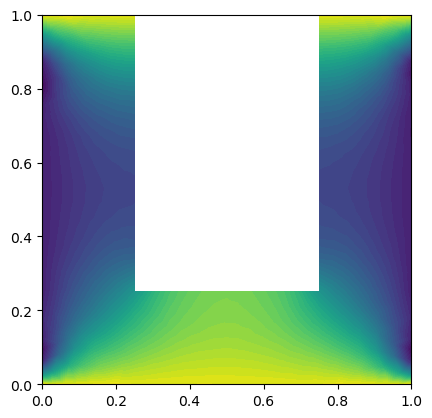

In [75]:
plot_mesh_3(u_np, coord_map) # for U shape, need to define outline to ensure no plotting in middle region

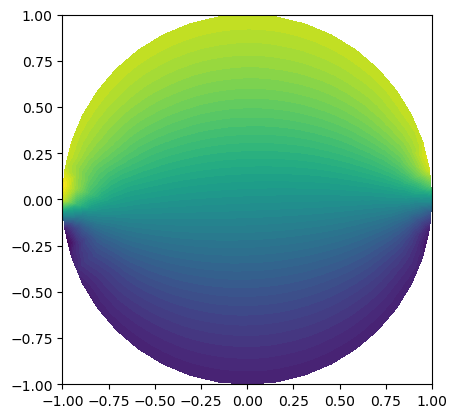

In [77]:
plot_mesh_1(u_np, coord_map) # for circle mtri does a good job

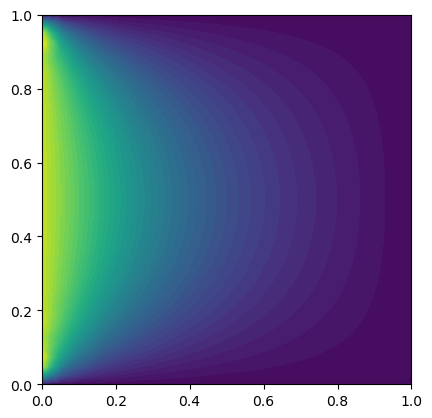

In [79]:
plot_mesh_1(u_np, coord_map) # for square mtri does a good job